In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Load the pre-trained Faster RCNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [0]:
# Import the class names as given in pytorch documentation.
CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

Load the image

In [0]:
!wget 'https://images.unsplash.com/photo-1562120965-8b3a641870a5?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=750&q=80' -O image.jpg

--2020-04-20 10:39:36--  https://images.unsplash.com/photo-1562120965-8b3a641870a5?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=750&q=80
Resolving images.unsplash.com (images.unsplash.com)... 151.101.38.208, 2a04:4e42:9::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.38.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89028 (87K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  86.94K  --.-KB/s    in 0.009s  

2020-04-20 10:39:37 (9.81 MB/s) - ‘image.jpg’ saved [89028/89028]



In [0]:
transform=transforms.ToTensor()

def load_image(img_path):
    img=Image.open(img_path)
    img=transform(img)
    img=img.unsqueeze(0)
    return img.to(device)

# converts (1,3,w,h) to (w,h,3)
def passable2img(x):
    x=x.squeeze(0)
    x=x.permute((1,2,0))
    return x

In [0]:
def get_prediction(img_path, threshold=0.8):
    img=load_image(img_path)
    pred = model(img)[0]
    box, labels, scores = pred['boxes'], pred['labels'], pred['scores']
    pred_classes = [CATEGORY_NAMES[i] for i in labels]
    box =[((round(i[0]),round(i[1])),(round(i[2]),round(i[3]))) for i in box.cpu().detach().numpy()]

    scores=(scores>threshold).cpu().numpy()
    box=[val for i,val in enumerate(box) if scores[i]]
    pred_classes=[val for i,val in enumerate(pred_classes) if scores[i]]
    return box, pred_classes 

In [0]:
def detect_object(img_path, threshold=0.8):
    box, classes = get_prediction(img_path)
    img = passable2img(load_image(img_path)).cpu().numpy()
    for i in range(len(box)):
        cv2.rectangle(img, box[i][0], box[i][1], (0, 255, 0), 2)
        cv2.putText(img, classes[i], box[i][0], cv2.FONT_HERSHEY_SIMPLEX, 1 , (0,255,0), 1)

    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


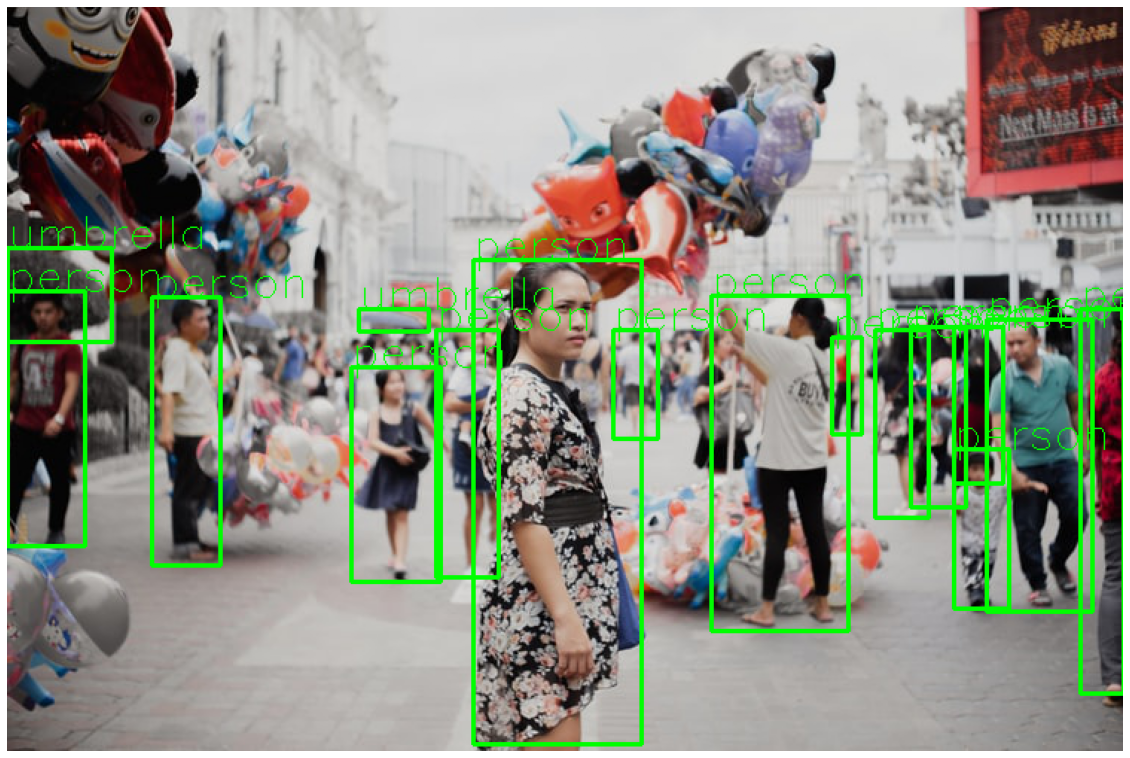

In [0]:
with torch.no_grad():
    detect_object(img_path, threshold=0.7)